In [65]:
# DEPENDENCIES
import glob
#from shutil import copyfile
import numpy as np
import pandas as pd
import logomaker
from scipy import stats
# LOCAL IMPORTS
#from indexing_classes import GPCRDBIndexing
import sse_func
import matplotlib.pyplot as plt
import template_finder as tf
import glob
import pickle
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator, FixedLocator)
# LOCAL IMPORTS
from gain_classes import GainDomain, GainCollection, Anchors, GPS
from indexing_classes import StAlIndexing

def find_pdb(name, pdb_folder):
    identifier = name.split("-")[0]
    target_pdb = glob.glob(f"{pdb_folder}/*{identifier}*.pdb")[0]
    return target_pdb

In [72]:
valid_collection = pd.read_pickle("../valid_collection.pkl")

In [ ]:
for i, gain in enumerate(valid_collection.collection[:10]):
    #if "A0A6J3E5X4" not in gain.name:
    #    continue
    #print(i)
    file_prefix = f"../test_stal_indexing/t_all_{i}"
    print("_"*30, f"\n{i} {gain.name}")
    #for i, hel in enumerate(gain.sda_helices):
    #    print(f"H#{i}: {hel[0]+gain.start}-{hel[1]+gain.start}")
    #for i, hel in enumerate(gain.sdb_sheets):
    #    print(f"S#{i}: {hel[0]+gain.start}-{hel[1]+gain.start}")
    element_intervals, element_centers, residue_labels, unindexed_elements, params = tf.assign_indexing(gain, 
                                                                                                file_prefix=file_prefix, 
                                                                                                gain_pdb=find_pdb(gain.name, '../all_pdbs'), 
                                                                                                template_dir='../r2_template_pdbs/', 
                                                                                                debug=False, 
                                                                                                create_pdb=False,
                                                                                                hard_cut={"S2":7,"S6":3,"H5":3},
                                                                                                patch_gps=True
                                                                                                )
    split_modes = {
        0:"No Split.",
        1:"Split by coiled residue.",
        2:"Split by disordered residue.",
        3:"Split by Proline/Glycine",
        4:"Split by hard cut.",
        5:"Overwrite by anchor priority."
    }
    if params["split_mode"] > 0:
        print(params["split_mode"], split_modes[params["split_mode"]])
    #print(element_intervals, element_centers, residue_labels, unindexed_elements, sep="\n")


In [ ]:
identifier = gain.name.split('-')[0]

out = tf.run_command(f"find ../sigmas/sigma_2/ -name \"*{identifier}*stride\"")
print("subl", out)
print("pymol", find_pdb(identifier, '../all_pdbs'))
print(gain.sequence[717-gain.start:725-gain.start])

In [ ]:
print(element_intervals, element_centers, residue_labels, unindexed_elements, params, sep="\n")

In [73]:
#offset information
def find_offsets(fasta_file, accessions, sequences):
    # searches through the accessions in the big sequence file,
    # finds the start for the provided sequence
    with open(fasta_file,"r") as fa:
        fa_data = fa.read()
        fasta_entries = fa_data.split(">")
    seqs = []
    headers = []
    offsets = []
    for seq in fasta_entries:
        # Fallback for too short sequences
        if len(seq) < 10: 
            continue
        data = seq.strip().split("\n")
        headers.append(data[0].split("|")[1]) # This is only the UniProtKB Accession Number and will be matched EXACTLY
        seqs.append("".join(data[1:]))
    
    heads = np.array(headers)
    for idx, accession in enumerate(accessions):
        seq_idx = np.where(heads == accession)[0][0]
        offset = sse_func.find_the_start(seqs[seq_idx], sequences[idx])
        #print(offset)
        offsets.append(offset)
    
    return offsets

all_accessions = [gain.name.split("-")[0].split("_")[0] for gain in valid_collection.collection]
all_sequences = ["".join(gain.sequence) for gain in valid_collection.collection]

fasta_offsets = find_offsets("/home/hildilab/projects/GPS_massif/uniprot_query/agpcr_celsr.fasta", 
                                 all_accessions, 
                                 all_sequences)

In [74]:
"""stal_indexing = StAlIndexing(valid_collection.collection[:10], 
                             prefix="../test_stal_indexing/test", 
                             pdb_dir='../all_pdbs/',  
                             template_dir='../r2_template_pdbs/', 
                             fasta_offsets=fasta_offsets,
                             n_threads=1,
                             debug=False)"""

"""stal_indexing = StAlIndexing(valid_collection.collection[200:300], 
                             prefix="../test_stal_indexing/t_class", 
                             pdb_dir='../all_pdbs/',  
                             template_dir='../r2_template_pdbs/',
                             n_threads=6,
                             debug=False)"""
"""import pickle
print(stal_indexing.indexing_dirs[0], stal_indexing.center_dirs[0], stal_indexing.intervals[0], sep="\n")
header, matrix = stal_indexing.construct_data_matrix(unique_sse=False)
stal_indexing.data2csv(header, matrix, "../test.stal_indexing.csv")

with open("stal_indexing.pkl","wb") as save:
    pickle.dump(stal_indexing, save)"""
print("potato.")
stal_indexing = pd.read_pickle("stal_indexing_u.pkl")

potato.


Perform Analysis and Graphical statistics for StAl_indexing.

In [75]:
# Function Block for parsing information
def get_loops(indexing_dir):
    # Returns a named dict with loop lengths, i.e. {"H1-H2":13, "H8-S1":12}
    inverted_dir = {sse[0] : (sse[1],ki) for ki, sse in indexing_dir.items()} # The begin of each sse is here {0:(13, "H2")}
    loop_dir = {}
    ordered_starts = sorted(inverted_dir.keys())
    for i, sse_start in enumerate(ordered_starts):
        if i == 0: 
            continue # Skip the first and go from the second SSE onwards, looking in N-terminal direction.
        c_label = inverted_dir[sse_start][1]
        n_end, n_label = inverted_dir[ordered_starts[i-1]]
        loop_dir[f"{n_label}-{c_label}"] = sse_start - n_end - 1
    return loop_dir

def get_sse_len(indexing_dir, total_keys):
    # Returns a dict with the length of each SSE in respective GAIN domain.
    len_dir = {x:0 for x in total_keys}
    for ki in indexing_dir.keys():
        start = indexing_dir[ki][0]
        end = indexing_dir[ki][1]
        len_dir[ki] = end - start + 1
    return len_dir

def get_pos_res(pos_dir, gain):
    # Returns a dict with the One-Letter-Code of each SSE position in the respective GAIN domain.
    pos_res = {k : gain.sequence[v-gain.start] for k,v in pos_dir.items() if v is not None and v-gain.start < len(gain.sequence)}
    return pos_res

def match_dirs(single_dir, collection_dir, exclude=[]):
    for k, v in single_dir.items():
        if v in exclude:
            continue
        if k not in collection_dir.keys():
            collection_dir[k] = [v]
            continue
        collection_dir[k].append(v)
    return collection_dir

def plot_hist(datarow, color, name, length):
    max = np.max(datarow)
    try: 
        dens = stats.gaussian_kde(datarow)
    except:
        print(np.unique(datarow))
        return
    fig = plt.figure(figsize=[4,2])
    fig.set_facecolor('w')
    n, x, _ = plt.hist(datarow, bins=np.linspace(0,max,max+1), histtype=u'step', density=True, color='white',alpha=0)
    plt.plot(x, dens(x),linewidth=2,color=color,alpha=1)
    plt.fill_between(x,dens(x), color=color,alpha=0.1)
    ax = plt.gca()
    ymax = ax.get_ylim()[1]
    val_string = f'{round(np.average(datarow),2)}±{round(np.std(datarow),2)}'
    plt.text(max, ymax*0.95, name, horizontalalignment='right', fontsize=14, verticalalignment='top')
    plt.text(max, ymax*0.8, val_string, horizontalalignment='right', fontsize=14, verticalalignment='top')
    plt.text(max, ymax*0.65, f"{round(len(datarow)/length*100, 1)}%", horizontalalignment='right', fontsize=14, verticalalignment='top')
    plt.xlabel('Element Length [Residues]')
    plt.ylabel('Relative density [AU]')
    plt.savefig(f'{name}_hist.svg')
    plt.show()
    plt.close(fig)

def parse_conservation(datarow, length):
    total = len(datarow)
    letters, counts = np.unique(np.array(datarow), return_counts=True)

    resid_counts = {}
    for i, res in enumerate(letters):
            resid_counts[int(counts[i])] = res
    
    sorted_counts = sorted(resid_counts.keys())[::-1]

    occupancy = round(total/length*100, 1)
    conserv_string = []
    residue_occupancies = [ int( x*100 / total ) for x in sorted_counts]
    for idx, occ in enumerate(residue_occupancies):
        if occ >= 5: conserv_string.append(f"{resid_counts[sorted_counts[idx]]}:{occ}%")

    return occupancy, ", ".join(conserv_string)

def construct_identifiers(intervals:dict, center_dir:dict, plddt_values:dict, max_id_dir:dict, name:str, seq=None, gain_start=0, debug=False):
    id_dir = {}
    plddts = {}
    sse_seq = {}
    if debug:
        print("DEBUG",f"{len(plddt_values) = }", f"{len(seq) = }", f"{gain_start = }", sep="\n\t")
    for sse in intervals.keys():
        if sse == 'GPS' :
            continue
        start = intervals[sse][0]
        end = intervals[sse][1]
        if end-start > 45:
            print(f"NOTE: SKIPPDING TOO LONG SSE WITH LENGTH {end-start}\n{name}: {sse}")
            continue
        center_resid = center_dir[f"{sse}.50"]
        first_resid = 50 - center_resid + start
        for k in range(end-start+1):
            if sse not in max_id_dir.keys():
                max_id_dir[sse] = []
            if first_resid+k not in max_id_dir[sse]:
                max_id_dir[sse].append(first_resid+k)
        id_dir[sse] = [first_resid+k for k in range(end-start+1)]
        plddts[sse] = [plddt_values[k] for k in range(start, end+1)]
        if seq is not None:
            sse_seq[sse] = [seq[k-gain_start] for k in range(start, end+1) if k-gain_start<len(seq)]
    if seq is None:
        sse_seq = None
    return max_id_dir, id_dir, plddts, sse_seq

def get_plddt_dir(file='all_plddt.tsv'):
    plddt_dir = {}
    with open(file) as f:
        data = [l.strip() for l in f.readlines()[1:]]
        for l in data:
            i,v  = tuple(l.split("\t"))
            plddt_dir[i] = [float(val) for val in v.split(",")]
    return plddt_dir

def make_id_list(id_dir):
    id_list = []
    for sse in id_dir.keys():
        for res in id_dir[sse]:
            id_list.append(f"{sse}.{res}")
    return id_list #np.array(id_list)

def compact_label_positions(id_collection, plddt_collection, sse_keys, debug=False):
    # Stacks label positions on one another
    label_plddts = {}
    for sse in sse_keys:
        label_plddts[sse] = {}

    for i in range(len(id_collection)):
        gain_positions = id_collection[i]
        plddt_positions = plddt_collection[i]
        if debug: 
            print(i,gain_positions, plddt_positions, sep="\n")
        for sse, v in gain_positions.items():
            if v == []:
                continue
            for j, pos in enumerate(v):
                pos = int(pos)
                if j >= len(plddt_positions[sse]):
                    continue
                if pos not in label_plddts[sse].keys():
                    label_plddts[sse][pos] = [plddt_positions[sse][j]]
                else:
                    label_plddts[sse][pos].append(plddt_positions[sse][j])

    return label_plddts

def construct_id_occupancy(indexing_dirs, center_dirs, length, plddt_dir, names, seqs, starts:list, debug=False):
    newkeys = ['H1','H1.D1','H1.E1','H1.F4','H2','H3','H4','H5','H6','S1','S2','S3','S4','S5','S6','S7','S8','S9','S10','S11','S12','S13']
    id_collection = []
    plddt_collection = []
    seq_collection = []
    all_id_dir = {x:[] for x in newkeys}
    for k in range(length):
        identifier = names[k].split("-")[0]
        plddt_values = plddt_dir[identifier]
        all_id_dir, id_dir, plddts, sse_seq = construct_identifiers(indexing_dirs[k], center_dirs[k], plddt_values, all_id_dir, names[k], seqs[k], starts[k], debug=debug)
        #print(k, sse_seq)
        id_collection.append(id_dir)
        #print(id_dir)
        plddt_collection.append(plddts)
        seq_collection.append(sse_seq)
    print("Completed creating value collection.")
    print(id_collection[0])
    print(plddt_collection[0])

    # Here, parse through the id_dirs to count the occurrence of positions per SSE
    # Dictionary to map any label identifier to a respective position.
    id_map = {}
    i = 0
    for sse in newkeys:
        for res in all_id_dir[sse]:
            id_map[f'{sse}.{res}'] = i 
            i += 1
    
    max_id_list = []
    for i, id_dict in enumerate(id_collection):
        max_id_list.append(make_id_list(id_dict))
    flat_id_list = np.array([item for sublist in max_id_list for item in sublist])
    print("Finished constructing flat_id_list.")
    labels, occ = np.unique(flat_id_list, return_counts=True)
    # Parse through labels, occ to generate the sse-specific data
    occ_dict = {labels[u]:occ[u] for u in range(len(labels))}
    # Transform occ_dict to the same format as label_plddts (one dict per sse):
    label_occ = {}
    for sse in newkeys:
        label_occ[sse] = {int(k[-2:]):v for k,v in occ_dict.items() if sse in k}
    #print(labels, occ)
    label_plddts = compact_label_positions(id_collection, plddt_collection, newkeys, debug=debug)
    label_seq = compact_label_positions(id_collection, seq_collection, newkeys, debug=debug)
    #print(labels)
    return label_plddts, label_occ, label_seq
    #[print(k, len(v)) for k,v in label_plddts.items()]

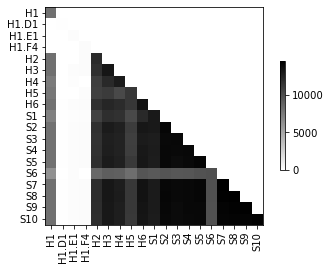

In [76]:
# OCCUPANCY MATRIX

#print(dir(stal_indexing))
#newkeys = ['H1',,'H2','H3','H4','H5','H6','H7','H8','S1','S2','S3','S4','S5','S6','S7','S8','S9','S10','S11','S12','S13']
newkeys = ['H1','H1.D1','H1.E1','H1.F4','H2','H3','H4','H5','H6','S1','S2','S3','S4','S5','S6','S7','S8','S9','S10','S11','S12','S13']
loop_lengths = {}
sse_lengths = {}
center_residues = {}
sse_matrix = np.zeros(shape=(len(stal_indexing.total_keys),len(stal_indexing.total_keys)))
for idx in range(stal_indexing.length):
    #Sanity Check - Do the identifiers match? Yes, they do.
    #if stal_indexing.names[idx].split("-")[0] != valid_collection.collection[idx].name.split("-")[0]:
    #    print(stal_indexing.names[idx].split("-")[0], valid_collection.collection[idx].name.split("-")[0])
    #    raise IndexError
    loop_lengths = match_dirs(get_loops(stal_indexing.intervals[idx]), loop_lengths)
    sse_lengths = match_dirs(get_sse_len(stal_indexing.intervals[idx], stal_indexing.total_keys), sse_lengths, exclude=[0])
    center_res = match_dirs(get_pos_res(stal_indexing.center_dirs[idx], valid_collection.collection[idx]), center_residues)

    present_sse = stal_indexing.intervals[idx].keys()
    for i, kk in enumerate(newkeys):
        for j in range(i,len(newkeys)):
            if kk in present_sse and newkeys[j] in present_sse:
                sse_matrix[j,i] += 1

plt.imshow(sse_matrix, cmap='gist_yarg')
plt.xticks(ticks= range(len(newkeys)), labels=newkeys, rotation=90)
plt.yticks(ticks= range(len(newkeys)), labels=newkeys)
plt.xlim(-0.5,18.5)
plt.ylim(18.5,-0.5)
cbar = plt.colorbar(shrink=0.5)
plt.savefig("stal_occ_map_unique.svg")


In [77]:
plddt_dir = get_plddt_dir('all_plddt.tsv')
all_starts = [ gain.start for gain in valid_collection.collection ]
#print(list(plddt_dir.keys())[:10])
plddt_values, occ_values, label_seq = construct_id_occupancy(stal_indexing.intervals, 
                                                             stal_indexing.center_dirs, 
                                                             stal_indexing.length, 
                                                             plddt_dir, 
                                                             stal_indexing.names, 
                                                             stal_indexing.sequences,
                                                             all_starts,
                                                             debug=False)

NOTE: SKIPPDING TOO LONG SSE WITH LENGTH 50
A0A2I3T0S0-A0A2I3T0S0_PANTR-Uncharacterizedprotein-Pan_troglodytes: H6
Completed creating value collection.
{'H1': [40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54], 'H2': [40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56], 'H3': [48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67], 'H4': [37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50], 'H5': [44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56], 'H6': [40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62], 'S1': [50, 51, 52, 53], 'S2': [48, 49, 50, 51, 52, 53, 54, 55, 56], 'S3': [48, 49, 50], 'S4': [49, 50, 51, 52], 'S5': [48, 49, 50, 51, 52, 53, 54, 55, 56], 'S6': [50, 51, 52], 'S7': [49, 50, 51, 52, 53, 54, 55, 56], 'S8': [44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54], 'S9': [49, 50, 51, 52, 53, 54], 'S10': [49, 50, 51], 'S11': [50, 51, 52, 53, 54, 55], 'S12': [47, 48, 49, 50, 51, 52, 53, 5

Plot the numerical statistics for each element.

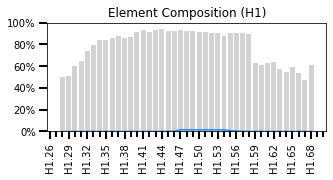

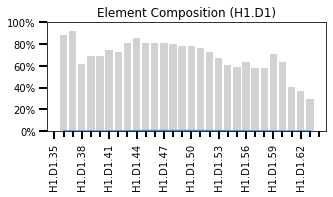

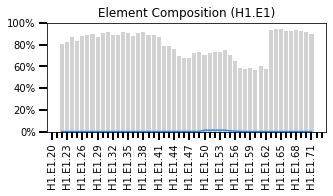

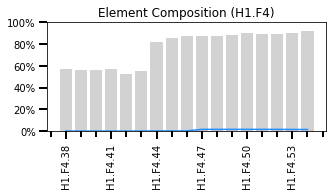

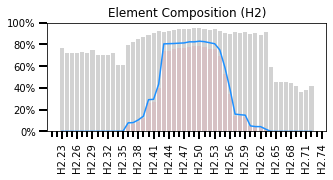

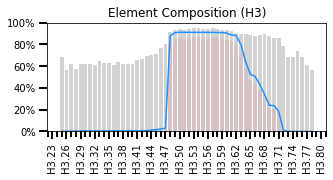

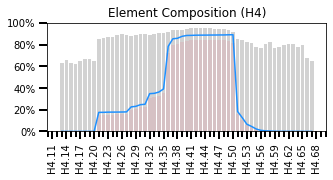

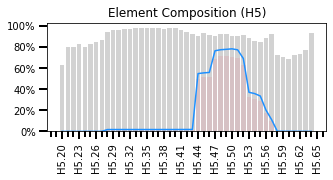

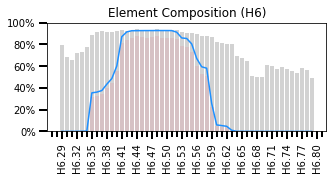

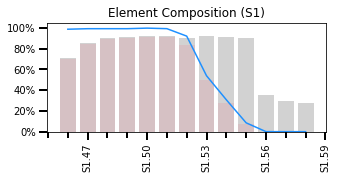

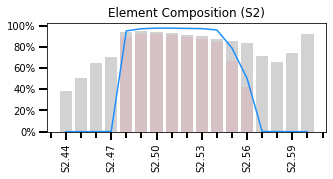

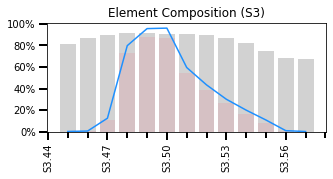

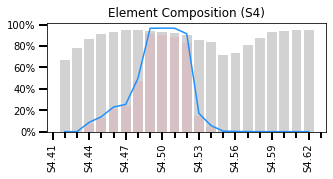

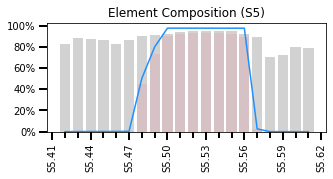

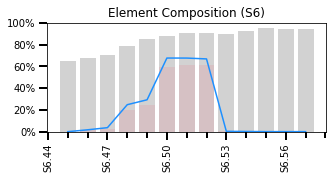

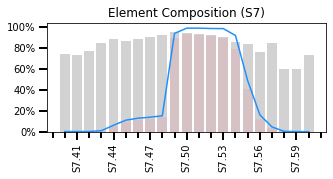

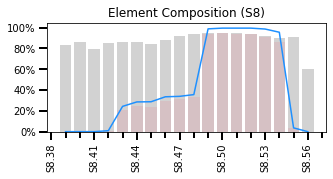

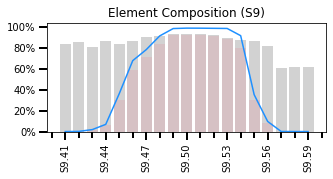

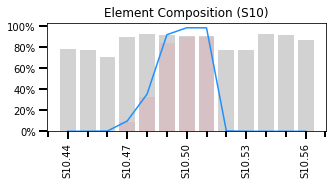

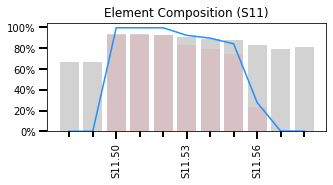

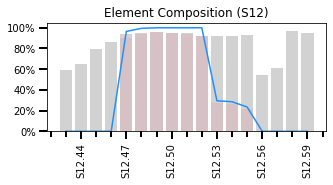

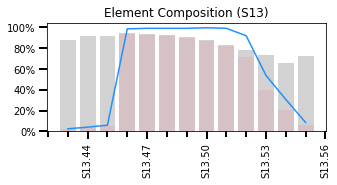

In [78]:
for sse in newkeys:
    # Transform the values first
    pp = plddt_values[sse]
    #print(occ_values[sse])
    av_pp = {k:np.average(np.array(v))/100 for k,v in pp.items()}
    #print(av_pp)
    norm_occ = {k:v/14435 for k,v in occ_values[sse].items()}
    xax = sorted(av_pp.keys())
    y_pp = [av_pp[x] for x in xax]
    y_occ = [norm_occ[x] for x in xax]
    norm_pp = np.array(y_pp)*np.array(y_occ)

    fig, ax = plt.subplots(figsize=[5,2])
    fig.set_facecolor('w')
    ax.xaxis.set_minor_locator(MultipleLocator(1)) #AutoMinorLocator())
    ax.xaxis.set_major_locator(FixedLocator([a for a in range(2,100,3)]))#MultipleLocator(3)))
    ax.tick_params(which='both', width=2)
    ax.tick_params(which='major', length=8)
    ax.tick_params(which='minor', length=6)
    plt.bar(xax,y_pp, color='silver', alpha=0.7)
    plt.plot(xax, y_occ, color='dodgerblue')
    plt.bar(xax, norm_pp, color='xkcd:lightish red', alpha=0.1)
    plt.title(f'Element Composition ({sse})')
    plt.yticks(ticks = [0, 0.2, 0.4, 0.6, 0.8, 1], labels = ['0%', '20%', '40%', '60%', '80%', '100%'])
    #plt.ylabel('')
    ax.set_xticklabels([f'{sse}.{str(int(v))}' for v in ax.get_xticks()], rotation=90)
    plt.savefig(f'../fig/stal_{sse}_stats.svg', bbox_inches='tight')
    plt.show()
    plt.close(fig)

Generate a DataFrame for AA-logoplots and plot them element-wise.

In [79]:
# GENERATE A FULL DATAFRAME FOR THE LABELED POSITIONS AND THEIR RESPECTIVE AA FREQUENCIES FOR LOGOPLOTS
sse_aa_freqs = {}
aastr = 'ACDEFGHIKLMNPQRSTVWYX'
cols = {aa:i for i,aa in enumerate(aastr)}
for sse in newkeys:
    sse_dict = label_seq[sse]
    aafreqs = np.zeros(shape=(len(sse_dict.keys()), 21))
    for p_index, pos in enumerate(sorted(sse_dict.keys())):
        aas, freq = np.unique(np.array(sse_dict[pos]), return_counts=True)
        for i, aa in enumerate(aas):
            aafreqs[p_index, cols[aa]] = freq[i]/14435
    sse_aa_freqs[sse] = aafreqs

In [80]:
# LOGOPLOTS FOR THE ELEMENTS

from matplotlib.ticker import FixedLocator

for sse in newkeys:

    lframe = pd.DataFrame(data=sse_aa_freqs[sse], columns=[c for c in aastr], index = sorted(plddt_values[sse].keys()))

    # Note down the first and last row where the occupation threshold is met.
    firstval = None
    for i, r in lframe.iterrows():
        if np.sum(r) > 0.05: 
            if firstval is None:
                firstval = i
            lastval = i
    print(firstval, lastval)
    subframe = lframe.truncate(before=firstval, after=lastval)
    #x_offset = sorted(plddt_values[sse].keys())[0]

    fig, ax = plt.subplots(figsize=[5,2])
    cons_logo = logomaker.Logo(subframe,
                                ax=ax,
                                color_scheme='chemistry',
                                show_spines=False,
                                font_name='DejaVu Sans Mono')

    fig.set_facecolor('w')
    ax.xaxis.set_minor_locator(MultipleLocator(1)) #AutoMinorLocator())
    ax.xaxis.set_major_locator(FixedLocator([a for a in range(2,100,3)]))#MultipleLocator(3))
    ax.tick_params(which='both', width=2)
    ax.tick_params(which='major', length=8)
    ax.tick_params(which='minor', length=6)
    ax.set_xticklabels([f'{sse}.{str(int(v))}' for v in ax.get_xticks()], rotation=90)
    cons_logo.draw()
    fig.tight_layout()
    fig.set_facecolor('w')
    plt.savefig(f"../fig/stal_conslogo_{sse}.svg", bbox_inches='tight')
    plt.close(fig)

40 58
None 58
None 58
None 58
36 60
48 71
21 53
44 57
35 61
48 54
48 56
47 55
44 54
48 56
48 52
44 56
43 54
44 56
47 51
50 56
47 55
45 55


In [63]:
# modify all stride files in place.
def modify_stride(stride_file, outfolder, phi_lim, psi_lim):
    with open(stride_file) as stride:
        d = stride.readlines()
    newdata = []
    for l in d:
        if not l.startswith("ASG") or l[24] != "E":
            newdata.append(l)
            continue

        i = l.split()
        angles = [float(i[7]), float(i[8])]
        adj_angles = [a+360 if a<0 else a for a in angles]
        if abs(adj_angles[0]-phi_lim[0]) > 2*phi_lim[1] or abs(adj_angles[1]-psi_lim[0]) > 2*psi_lim[1]:
            # print("outlier found.", l, sep="\n")
            k = l[:24]+"e"+l[25:]
            newdata.append(k)        
            continue
        
        newdata.append(l)
    
    with open(f"{outfolder}/{stride_file.split('/')[-1]}", 'w') as out:
        out.write("".join(newdata))

In [64]:
import glob
stride_files = glob.glob("/home/hildilab/projects/agpcr_nom/sigmas/sigma_2/*")
phi_lim = [245.248, 30.129]
psi_lim = [136.615, 33.950]
outfolder = "/home/hildilab/projects/agpcr_nom/sigmas/sigma_2_all"

for stride_file in stride_files:
    modify_stride(stride_file, outfolder, phi_lim, psi_lim)